# DATA522 Final Exploration

## Library choice

* **PyArrow**: The dataset we were using was only available in the Parquet format
* **OCRMac**: We found that EasyOCR, while cross-platform, performed much worse than the built-in Apple OCR model, for which OCRMac provides a wrapper. We did use EasyOCR for our student-contributed lecture, but if we were to generate our dataset with EasyOCR, it would still be running today.
* **Transformers**: Transformers is used to download and run the `distilbert` sentiment analysis model.

## Data

Our data is available on HuggingFace at https://huggingface.co/datasets/afmck/peanuts-flan-t5-xl. Because of the size of the dataset, we elected to clone the data files without uploading them to our repository.

In [65]:
# Install libraries for reading in Parquet and OCR
%pip install pyarrow
# If you run this on windows your computer will explode :-)
%pip install ocrmac
# %pip install pytesseract
# %pip install easyocr

# Pre-trained sentiment analysis model
%pip install transformers

# CV2 (required for image operations)
%pip install opencv-python

# NLTK (required for text analysis)
%pip install nltk


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/ari/Dev/miniconda3/envs/py313/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/ari/Dev/miniconda3/envs/py313/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/ari/Dev/miniconda3/envs/py313/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/ari/Dev/miniconda3/envs/py313/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━

In [84]:
# Import libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import easyocr
from ocrmac import ocrmac
import cv2
import PIL
# necessary for distilbert pipeline
from transformers import pipeline
# natural language toolkit
import nltk
# something is Not regular about these expressions
import re
# we don't know what this is
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/ari/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Get all data Parquets
def read_dataset(dirname):
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    return [
        pd.
            read_parquet(
                f'{dirname}/{filename}'
            )
            .drop(columns = ['caption']) 
        for filename in training_filenames
    ]

In [5]:
# load the easyOCR library -- removed because we decided to use OCRMac instead
# state_easyocr = {
#     "reader": easyocr.Reader(['en'])
# }

# load the distilbert pipeline
state_sentiment = {
    "pipeline": pipeline("sentiment-analysis")
}

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [6]:
# stolen from https://stackoverflow.com/questions/17170752/python-opencv-load-image-from-byte-string
# (shamelessly)
def bytes2cv2(image):
    # images are stored as bytes, which we will cast into 8-bit ints
    img_bytes = image['bytes']
    return cv2.imdecode(
        np.frombuffer(
            img_bytes, 
            np.uint8
        ),
        # the glory of color
        cv2.IMREAD_COLOR_RGB
    )

# show a given image from the original dataset
def imshow(image):
    decoded_image = bytes2cv2(image)
    plt.imshow(decoded_image)

# use the distilbert model to get the sentiment of an image (between -1 and 1, depending on the confidence)
def analyze_sentiment(text, state_sentiment):
    sentiment = state_sentiment["pipeline"](text)[0]
    if sentiment["label"] == "NEGATIVE":
        return -1 * sentiment["score"]
    elif sentiment["label"] == "NEUTRAL":
        return 0
    return sentiment["score"]

# def easyocr_filtertext(read_text):
#     return ' '.join(read_text).upper()
    
# def ocr_easyocr(image, state):
#     decoded_image = bytes2cv2(image)
#     return easyocr_filtertext(state['reader'].readtext(decoded_image, detail = 0))

# use OCRMac to read text from an image
def ocr_ocrmac(image):
    pil_image = PIL.Image.fromarray(
        bytes2cv2(image)
    )
    ocr_result = ocrmac.text_from_image(
        pil_image
    )
    # Get just the text from the images
    return ' '.join(
        [
            ocr_tuple[0] 
            for ocr_tuple 
            in ocr_result
        ]
    )


def ocr_and_text_sentiment_row(row):
    text_ocrmac = ocr_ocrmac(row.image)
    sentiment_ocrmac = analyze_sentiment(text_ocrmac, state_sentiment)
    return pd.Series(
        {
            "text_ocrmac": text_ocrmac,
            "sentiment_ocrmac": sentiment_ocrmac
        }
    )

# Create pared-down dataset
def ocr_and_text_sentiment(df):
    df_ocr = pd.concat([df, df.apply(
        ocr_and_text_sentiment_row,
        axis = 1,
        # Expand the series into new columns
        result_type = 'expand'
    )], axis = 1)
    return df_ocr

# This function takes an extremely long time to run
# Run at your own peril
def create_pared_dataset(dirname):
    training_parquets = read_dataset(dirname)
    
    for i, training_parquet in enumerate(training_parquets):
        # Do not save image data, that would be insane
        (
            ocr_and_text_sentiment(training_parquet)
            # The pared dataset will not contain the original images but will contain both
            # OCR results and sentiment analysis scores
                .drop(columns = 'image')
                .to_parquet(f'{dirname}/parquet_{i}-sentiment.parquet')
        )
def read_pared_dataset(dirname):
    sentiment_filenames = sorted([
        filename for filename in os.listdir(dirname) if filename.endswith('.parquet') and not filename.startswith('train')
    ])
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    sentiment_parquets = [
        pd.read_parquet(f'{dirname}/{filename}').assign(filename = f'{dirname}/{training_filenames[idx]}') 
        for idx, filename in enumerate(sentiment_filenames)
    ]
    return pd.concat(sentiment_parquets).reset_index().rename(columns = {'index': 'row_within_file'})

# Get an image from the original dataset given a row from the pared-down dataset
def get_image(row):
    filename = row.filename
    row_within_file = row.row_within_file
    imshow(pd.read_parquet(filename).image.loc[row_within_file])

## graph time
##### graph time

In [11]:
sentiment_dataset = read_pared_dataset('./data')

In [53]:
sns.set_theme()
# sns.set_palette(
#     sns.color_palette("flare")
# )

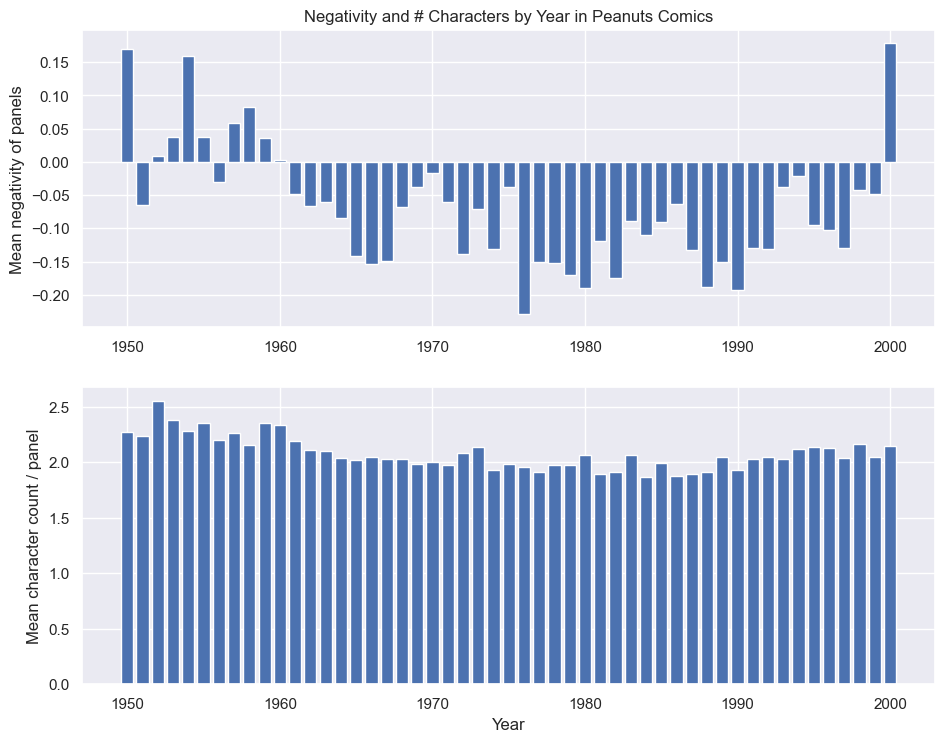

In [54]:
sentiment_dataset_n_characters = sentiment_dataset.assign(
    n_characters = sentiment_dataset.characters.apply(lambda characters: len(characters)),
    positive_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac > 0), 
    negative_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac < 0)
)

plots_0_data = (
    sentiment_dataset_n_characters
        .select_dtypes(exclude = ['object'])
        .groupby('year').agg(
            {'positive_sentiment': 'sum',
            'negative_sentiment': 'sum',
            'n_characters': 'mean'}
        )
)

fig, ax = plt.subplots(2, 1, figsize = (11, 8.5))

ax[0].bar(plots_0_data.index, (
            plots_0_data.positive_sentiment - plots_0_data.negative_sentiment) /
            (plots_0_data.positive_sentiment + plots_0_data.negative_sentiment)
         )
ax[0].set_ylabel("Mean negativity of panels")
ax[1].set_ylabel("Mean character count / panel")
ax[1].set_xlabel("Year")
ax[1].bar(plots_0_data.index, plots_0_data.n_characters)
ax[0].set_title("Negativity and # Characters by Year in Peanuts Comics")
plt.show()


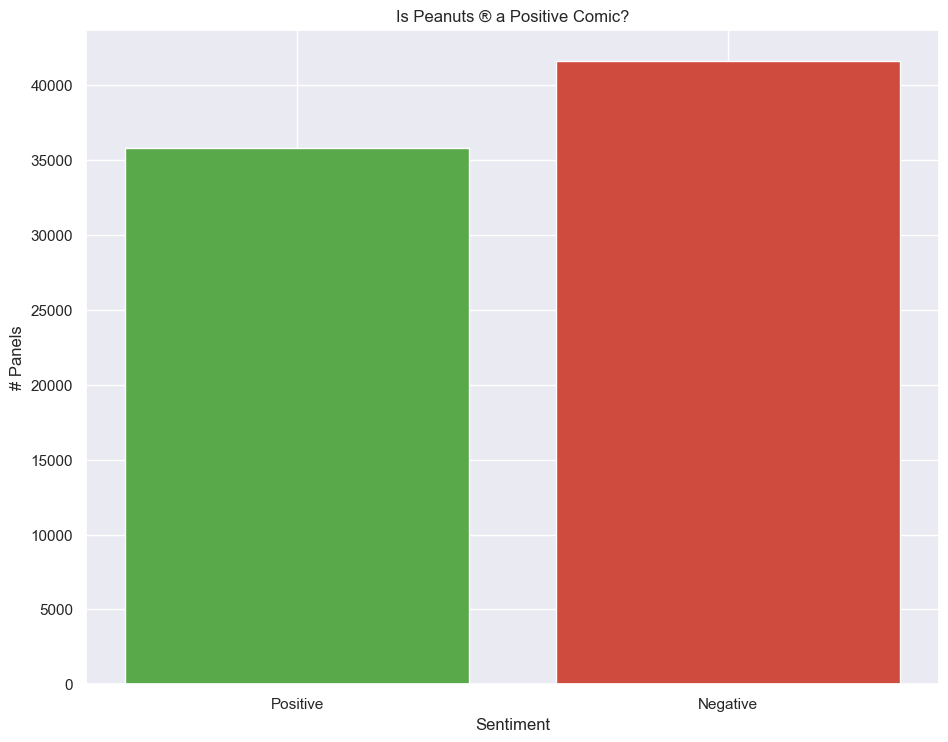

In [63]:
plots_1_data = plots_0_data[["positive_sentiment", "negative_sentiment"]].sum()
fig, ax = plt.subplots(figsize = (11, 8.5))
ax.bar(["Positive", "Negative"], [
    plots_1_data.positive_sentiment,
    plots_1_data.negative_sentiment
],
      color = ["#59A94A", "#CF4B3E"])
ax.set_ylabel("# Panels")
ax.set_xlabel("Sentiment")
ax.set_title("Is Peanuts ® a Positive Comic?")
plt.show()

In [142]:
# generate The String
all_peanut_text = re.sub(
        # Remove common non-text words
        r'([^\w\s]|United|Feature|Syndicate|19[0-9][0-9]|2000)',
        "",
        "\n"
        .join(sentiment_dataset.text_ocrmac.to_list())
        .replace("15", "IS")
        .replace("WARI", "WAR I")
        .replace("WARII", "WAR II")
        .replace("OL", "OLD")
        .replace("OLE", "OLD")
        .replace("OLDD", "OLD")
).upper()

# tokens from The String
peanut_tokens = nltk.word_tokenize(all_peanut_text)

# find 2-, 3-, and 4-word phrases
collocation_finders = [
    collocation_finder.from_words(peanut_tokens) for collocation_finder in
    (
        nltk.collocations.BigramCollocationFinder,
        nltk.collocations.TrigramCollocationFinder,
        nltk.collocations.QuadgramCollocationFinder
    )
]
association_measures = (
    nltk.collocations.BigramAssocMeasures,
    nltk.collocations.TrigramAssocMeasures,
    nltk.collocations.QuadgramAssocMeasures
)

In [143]:
n = 100
best_ngrams = [
    collocation_finder.nbest(association_measure.student_t, n)
    for collocation_finder, association_measure in
    zip(
        collocation_finders,
        association_measures
    )
]

In [144]:
[[" ".join(phrase) for phrase in ngram] for ngram in best_ngrams]

[['CHARLIE BROWN',
  'IN THE',
  'GOING TO',
  'DO YOU',
  'TO BE',
  'I DONT',
  'THIS IS',
  'I THINK',
  'HAVE TO',
  'ON THE',
  'ARE YOU',
  'OF THE',
  'HAVE A',
  'I CANT',
  'I HAVE',
  'YOU KNOW',
  'THE WORLD',
  'IF YOU',
  'WANT TO',
  'I WAS',
  'YOU THINK',
  'OUT OF',
  'ALL RIGHT',
  'A LITTLE',
  'IT WAS',
  'DID YOU',
  'KNOW WHAT',
  'KIND OF',
  'ALL THE',
  'THE DOCTOR',
  'YOU HAVE',
  'DONT KNOW',
  'I CAN',
  'IF I',
  'YOU CAN',
  'IM NOT',
  'IM GOING',
  'TO GET',
  'HEE HEE',
  'TO DO',
  'GOOD GRIEF',
  'I KNOW',
  'WHAT DO',
  'A GOOD',
  'A LOT',
  'I THOUGHT',
  'HOW ABOUT',
  'I HATE',
  'LIKE TO',
  'I GUESS',
  'HERES THE',
  'GON NA',
  'FOR THE',
  'SORT OF',
  'BE A',
  'YOU DONT',
  'IN A',
  'TO SEE',
  'YES MAAM',
  'YOU WANT',
  'THANK YOU',
  'I DIDNT',
  'AND THEN',
  'THE FIRST',
  'BUT I',
  'WHAT ARE',
  'FOR A',
  'I JUST',
  'OF COURSE',
  'HA HA',
  'I WONDER',
  'TRY TO',
  'I AM',
  'AT THE',
  'THE BALL',
  'YOU SHOULD',
  'IS A',
  